In [1]:
import cppyy
import copy
import ROOT
import os
include = os.path.join("./fastforest", 'include')
lib = os.path.join("./fastforest", 'lib')
ROOT.gSystem.AddIncludePath(f"-I{include}")
ROOT.gSystem.AddLinkedLibs(f"-L{lib} -lfastforest")
ROOT.gSystem.Load(f"{lib}/libfastforest.so.1")
ROOT.gSystem.CompileMacro("ml_helpers.cpp", "kO")

ff_models = ROOT.get_fastforests("models/", 20)
ff_even = ff_models['even']
ff_odd = ff_models['odd']
from xgboost import XGBClassifier
xgb_even = XGBClassifier()
xgb_even.load_model('models/model_even.json')
xgb_odd = XGBClassifier()
xgb_odd.load_model('models/model_odd.json')

import numpy as np
from features import ml_features_config
from matplotlib import pyplot as plt
import hist

Welcome to JupyROOT 6.28/04


In [2]:
def rdf2np(arrays, dimensions=3):
    if dimensions == 2:
        result = np.empty((len(arrays), len(arrays[0])))
        for x in range(result.shape[0]):
            for y in range(result.shape[1]):
                result[x,y] = arrays[x][y]
    elif dimensions == 3:
        result = np.empty((len(arrays), len(arrays[0]), len(arrays[0][0])))
        for x in range(result.shape[0]):
            for y in range(result.shape[1]):
                for z in range(result.shape[2]):
                    result[x, y, z] = arrays[x][y][z]
    else: raise NotImplementedError

    return result

def get_rdf_input_features():
    
    feature_names = [feature.name for feature in ml_features_config]
    feature_names = feature_names.__str__().replace("[","{").replace("]","}").replace("'","")

    df = ROOT.RDataFrame("features", "features/ttbar_nominal.root")
    df = df.Define("features", f"ROOT::VecOps::RVec<ROOT::RVecF>({feature_names})")
    input_features = df.AsNumpy(["features"])["features"]

    return rdf2np(input_features).transpose(0,2,1)

def get_xgb_input_features():
    return np.load('/home/andrii/analysis-grand-challenge/analyses/cms-open-data-ttbar/arrays/features/ttbar_nominal.npy')

In [3]:
def rdf_predict_proba(ff_model, features):
    inputs = features.transpose(0,2,1).tolist()
    rdf_scores = [ 
        ROOT.inference(
                ROOT.VecOps.RVec[ROOT.RVecD](input), 
                ff_model,
        ) for input in inputs 
    ]
    return rdf2np(rdf_scores, dimensions=2)

def xgb_predict_proba(xgb_model, features):
    return np.array(
        [xgb_model.predict_proba(features_i)[:,1] for features_i in features]
    )

def _predict_proba(model, features):
    if isinstance(model, XGBClassifier):
        return xgb_predict_proba(model, features)
    elif isinstance(model, cppyy.gbl.fastforest.FastForest):
        return rdf_predict_proba(model, features)

def predict_proba(models_list, input_features):
    assert (len(models_list) == len(input_features))
    return tuple(
        _predict_proba(model=models_list[i], features=input_features[i]) for i in range(len(models_list))
    )

def apply_argmax(proba_scores, features):
    res = np.empty((features.shape[0],features.shape[-1]))
    for event in range(proba_scores.shape[0]):
        res[event,:] = features[ event, proba_scores[event].argmax() , : ]
    return res

def inference(model, features):
    return apply_argmax(
        predict_proba(model, features),
        features
    )
    
    

In [4]:
input_features_xgb = get_xgb_input_features()
input_features_rdf = get_rdf_input_features()
print(
    f"maximum input features deviation: {np.abs(input_features_xgb-input_features_rdf).max()}"
)

maximum input features deviation: 0.0577392578125


In [5]:
(
scores_xgb_odd, scores_xgb_even, 
scores_rdf_odd, scores_rdf_even 
) = predict_proba(
        models_list=(xgb_odd, xgb_even, ff_odd, ff_even), 
        input_features=(input_features_xgb,)*2+(input_features_rdf,)*2
)

In [6]:
print(
    f"maximum probability scores deviation with odd models: {np.abs(scores_rdf_odd-scores_xgb_odd).max()}"
)
print(
    f"maximum probability scores deviation with even models: {np.abs(scores_rdf_even-scores_xgb_even).max()}"
)

maximum probability scores deviation with odd models: 0.02358025312423706
maximum probability scores deviation with even models: 0.01622951030731201


In [7]:
res_xgb_odd = apply_argmax(scores_xgb_odd, input_features_xgb)
res_xgb_even = apply_argmax(scores_xgb_even, input_features_xgb)
res_rdf_odd = apply_argmax(scores_xgb_odd, input_features_rdf)
res_rdf_even = apply_argmax(scores_xgb_even, input_features_rdf)

print (
    f"maximum features deviation with odd models: {np.abs(res_rdf_odd-res_xgb_odd).max()}"
)
print (
    f"maximum features deviation with even models: {np.abs(res_rdf_even-res_xgb_even).max()}"
)


maximum features deviation with odd models: 0.015479087829589844
maximum features deviation with even models: 0.015479087829589844


In [8]:
def get_histograms(features_rdf,features_xgb):
    ml_hist_dict = {}
    for feature in ml_features_config:
        ml_hist_dict[feature.name] = (
            hist.Hist.new.Reg(feature.binning[0],
                            feature.binning[1],
                            feature.binning[2],
                            name="observable",
                            label=feature.title)
            .Weight()
        )

    ml_hist_dict_rdf = copy.deepcopy(ml_hist_dict)
    ml_hist_dict_xgb = copy.deepcopy(ml_hist_dict)

    x_sec = 729.84
    lumi = 3378
    nevts_total = 1334428
    weight = x_sec * lumi / nevts_total
    for i, feature in enumerate(ml_features_config):
        ml_hist_dict_rdf[feature.name].fill(observable=features_rdf[:,i], weight=weight)
        ml_hist_dict_xgb[feature.name].fill(observable=features_xgb[:,i], weight=weight)
    return ml_hist_dict_rdf, ml_hist_dict_xgb

In [9]:
histos_rdf_odd, histos_xgb_odd = get_histograms(res_rdf_odd, res_xgb_odd)
histos_rdf_even, histos_xgb_even = get_histograms(res_rdf_even, res_xgb_even)

In [15]:
def plot_histos(ml_hist_dict_rdf, ml_hist_dict_xgb):
    fig, axs = plt.subplots(10,2,figsize=(14,40))
    for i, feature in enumerate(ml_features_config):
        if i<10: 
            column=0
            row=i
        else: 
            column=1
            row=i-10
        ml_hist_dict_rdf[feature.name].plot(ax=axs[row,column])
        ml_hist_dict_xgb[feature.name].plot(ax=axs[row,column])
        deviation = np.abs( 
                    ml_hist_dict_rdf[feature.name].values() - ml_hist_dict_xgb[feature.name].values() 
                ).max()
        if not deviation == 0: print(
            f"{feature.name}'s maximum deviation is {deviation}"
        )
    return fig, axs
    

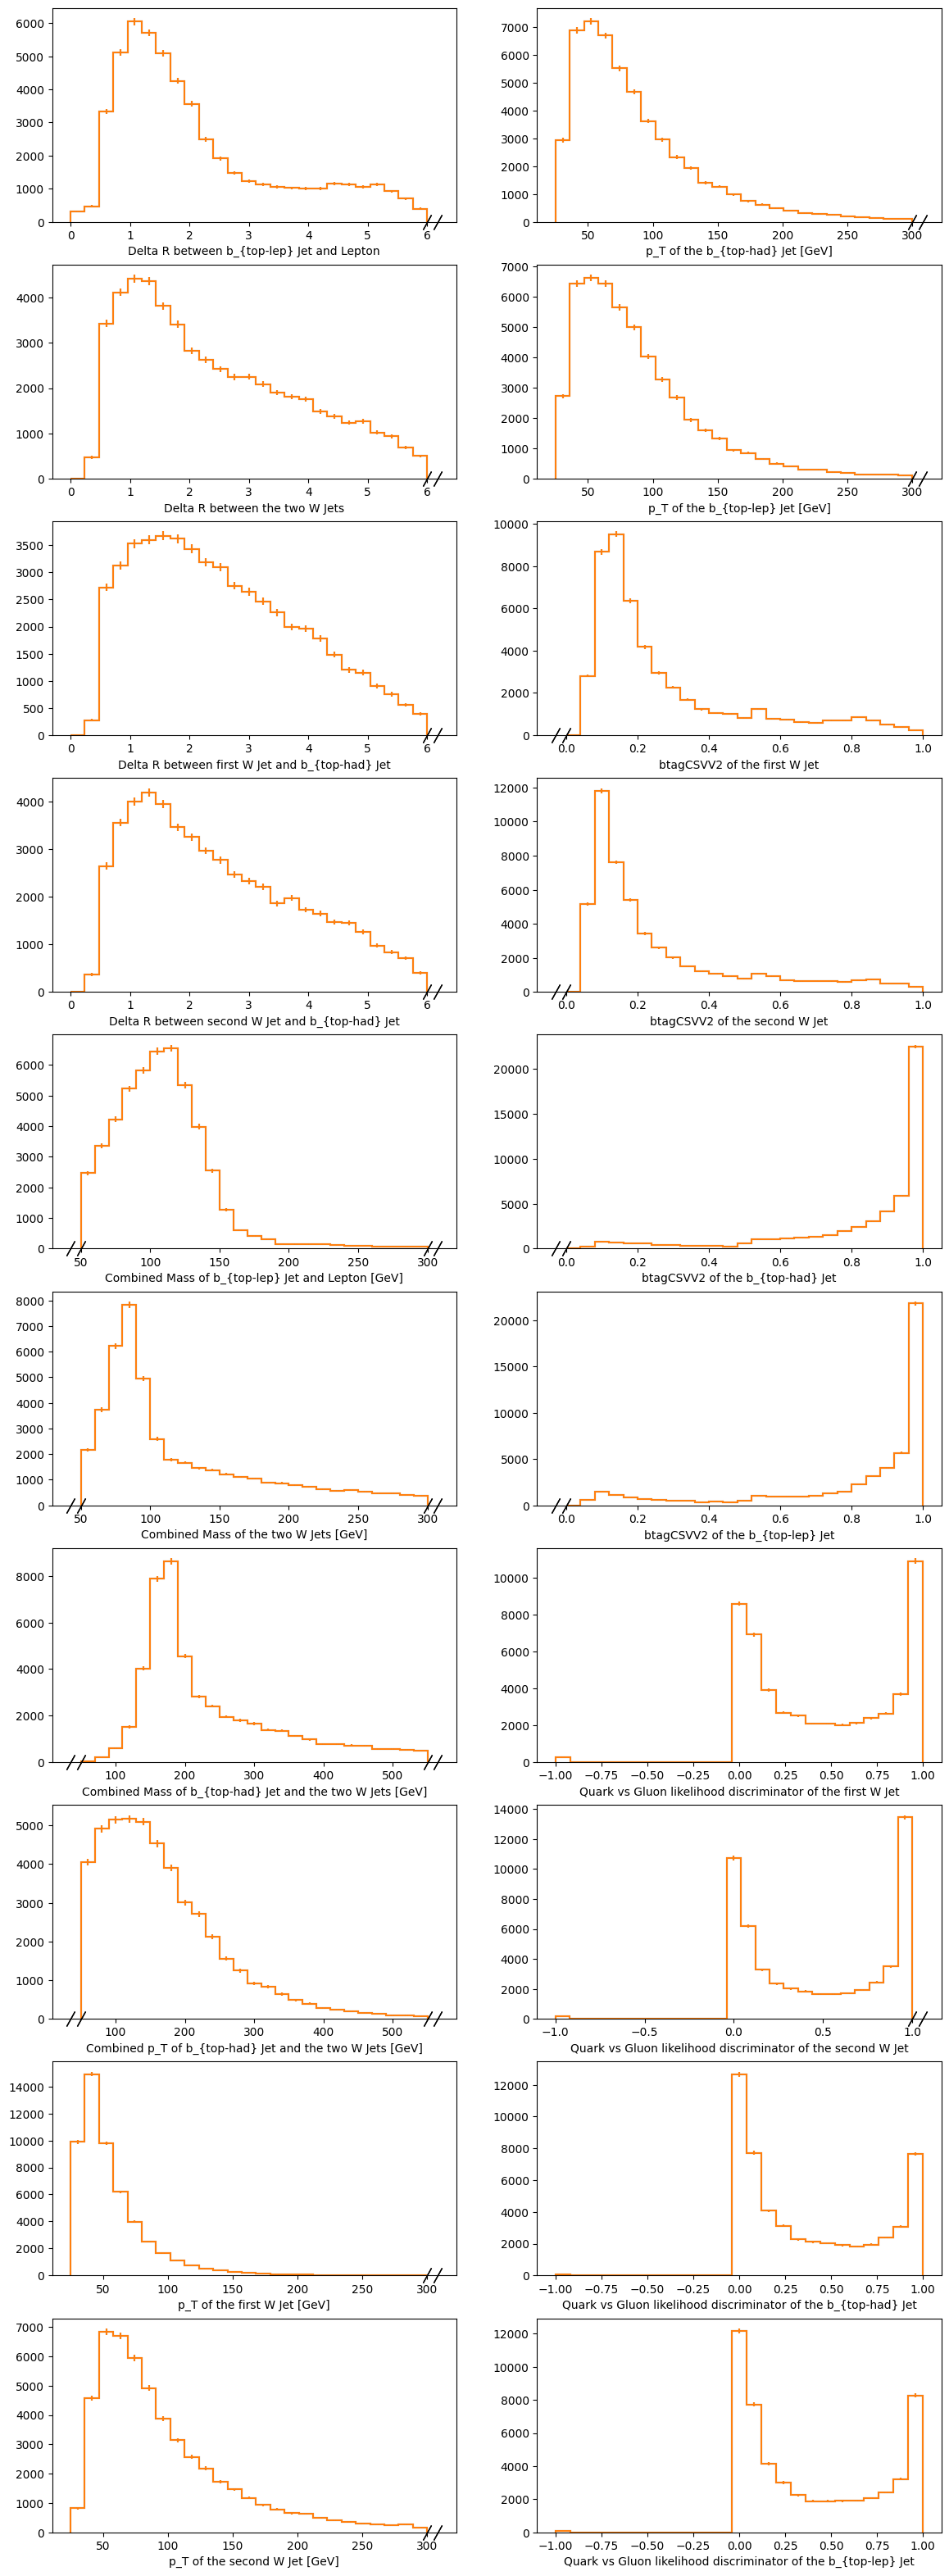

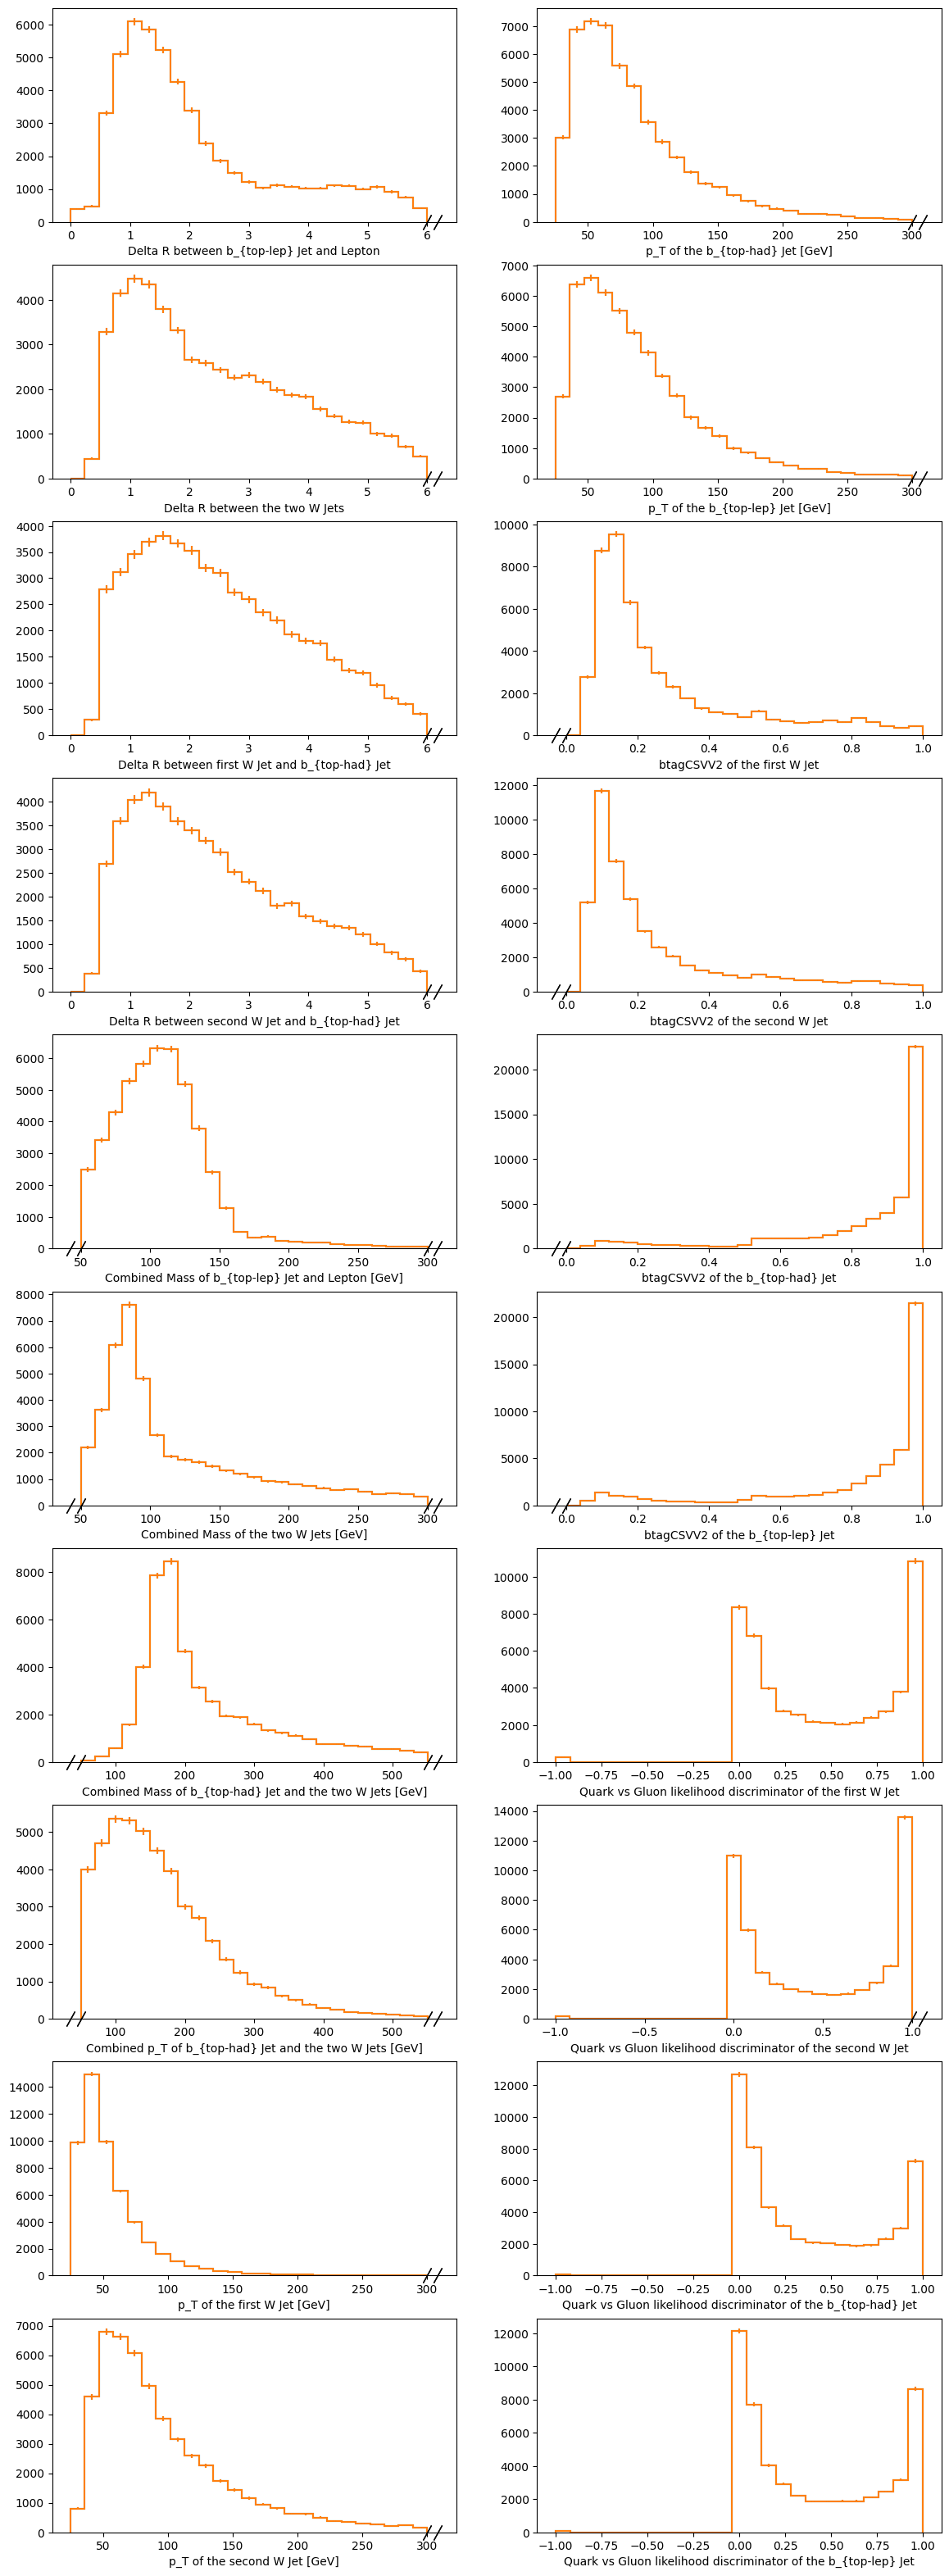

In [17]:
fig, axs = plot_histos(histos_rdf_odd, histos_xgb_odd)
fig, axs = plot_histos(histos_rdf_even, histos_xgb_even)
